# **NYC TAXI FARE PREDICTION**


In this Notebook anomalous data is removed and the dataset is prepared in order to make a first linear regression using the sklearn library.

# Data Cleaning & Visualization

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/content/nyc_taxi_data.csv') 

In [ ]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1048575 non-null  object 
 1   fare_amount        1048575 non-null  float64
 2   pickup_datetime    1048575 non-null  object 
 3   pickup_longitude   1048575 non-null  float64
 4   pickup_latitude    1048575 non-null  float64
 5   dropoff_longitude  1048565 non-null  float64
 6   dropoff_latitude   1048565 non-null  float64
 7   passenger_count    1048575 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 64.0+ MB


In [ ]:
data.describe()   # check if fare amounts have reasonable values, max and min

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048565e+06,1.048565e+06,1.048575e+06
mean,1.134548e+01,-7.252724e+01,3.993094e+01,-7.252750e+01,3.992496e+01,1.684902e+00
std,9.820072e+00,1.200798e+01,7.725806e+00,1.141154e+01,8.529585e+00,1.323155e+00
min,-4.490000e+01,-3.377681e+03,-3.116285e+03,-3.383297e+03,-3.114339e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073496e+01,-7.399138e+01,4.073406e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075267e+01,-7.398014e+01,4.075318e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076714e+01,-7.396367e+01,4.076812e+01,2.000000e+00
max,5.000000e+02,2.522271e+03,2.621628e+03,1.717003e+03,1.989728e+03,2.080000e+02


Identification of location dispersion for pickup and dropoff points of each taxi ride

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'pickup locations')

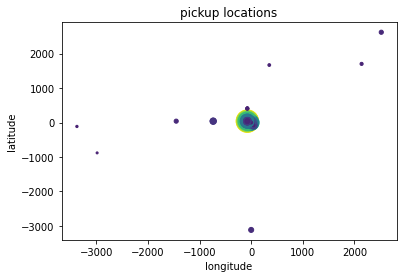

In [ ]:
plt.scatter(data.iloc[:,3], data.iloc[:,4],s=data.fare_amount, c=data.fare_amount)  # plot dots with brighter colour and radius for higher fare amount
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("pickup locations")

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 1.0, 'dropoff locations')

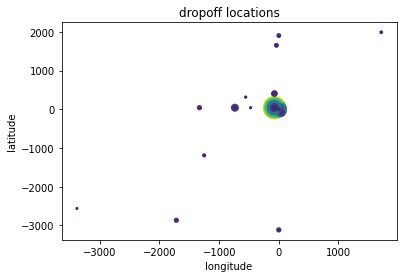

In [ ]:
plt.scatter(data.iloc[:,5], data.iloc[:,6],s=data.fare_amount, c=data.fare_amount)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("dropoff locations")

Outliers in fare amount are for sure all fare amounts <= 0. 
Longitude and latitude need also to be limited in a range. NYC lies always 
at values around 40 and 73 respectively.

In [ ]:
def Thresholds(statistics,column):                          # Function for returning min and max of the interquartile range, given the dataset and column
  Q1 = statistics.describe().iloc[4,column]
  Q3 = statistics.describe().iloc[6,column]
  IQR_Inter=1.5*(Q3-Q1)       ## inter-quartile-range, 75% of the values that lie in the middle of the dataseries
  minThreshold=Q1-IQR_Inter   ## min and max value of the inter-quartile-range
  maxThreshold=Q3+IQR_Inter
  return minThreshold, maxThreshold


In [ ]:
fare_bounds=Thresholds(data,0)                # 0 - fare amount column
data = data[data.fare_amount<fare_bounds[1]]  # remove upper outliers above 75% of the series

In [ ]:
data = data[data.fare_amount>1]   # fare higher than 1 dollar make sense
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,957881.000000,957881.000000,957881.000000,957874.000000,957874.000000,957881.000000
mean,8.930330,-72.545900,39.944318,-72.548937,39.935544,1.681030
std,4.139647,12.066922,7.141774,11.427154,8.680700,1.322502
min,1.500000,-3377.680935,-880.627428,-3383.296608,-3114.338567,0.000000
25%,5.700000,-73.992348,40.735933,-73.991661,40.735547,1.000000
50%,8.000000,-73.982203,40.752642,-73.980917,40.753329,1.000000
75%,11.000000,-73.969042,40.766532,-73.966644,40.767503,2.000000
max,22.220000,2522.271325,2621.628430,1717.003405,1989.728077,208.000000


In [ ]:
## extract data with passenger count 0
data = data[data.passenger_count>0]
## The existence of this data can be explained by booking cancellation

In [ ]:
data = data[data.pickup_latitude>=-90]      #latitude and longitude must be in range -90 to 90 degrees 
data = data[data.dropoff_latitude<=90]
data = data[data.pickup_latitude<=90]
data = data[data.dropoff_latitude>=-90]

data = data[data.pickup_longitude>=-90]      
data = data[data.dropoff_longitude<=90]
data = data[data.pickup_longitude<=90]
data = data[data.dropoff_longitude>=-90]


Still after having geographical coordinates which exist, cleaning datapoints which lie outside the city needs to be done. 

In [ ]:
data = data[data.pickup_latitude>=40]     ## data cleaning of datapoints outside the city
data = data[data.pickup_latitude<=41]
data = data[data.dropoff_latitude>=40]
data = data[data.dropoff_latitude<=41]

data = data[data.pickup_longitude<=-73]
data = data[data.pickup_longitude>=-74.5]
data = data[data.dropoff_longitude<=-73]
data = data[data.dropoff_longitude>=-74.5]

## Data Analysis and feature extraction

In [ ]:
## DISTANCE CALCULATION BETWEEN START AND END LATITUDE AND LONGITUDE COORDINATES CONSIDERING WITH THE ELLIPSOIDAL MODEL OF THE EARTH##

from geopy.distance import vincenty

m = len(data)
D = []            # Create distance array

for i in range (m):                         # Assign to each record the distance
 start = (data.iloc[i,4], data.iloc[i,3])    # Create start and end points for each ride to insert in the distance calculation function
 finish = (data.iloc[i,6], data.iloc[i,5])
 D.append(vincenty(start, finish).km)

In [ ]:
## Add distance to most recent dataset
data['D'] = D
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,D
count,934337.000000,934337.000000,934337.000000,934337.000000,934337.000000,934337.000000,934337.000000
mean,8.937186,-73.979959,40.752036,-73.978252,40.752384,1.687405,2.511716
std,4.138259,0.022955,0.024157,0.024124,0.026679,1.303823,1.876286
min,2.500000,-74.494497,40.060920,-74.481633,40.065162,1.000000,0.000000
25%,5.700000,-73.992571,40.737293,-73.991858,40.737125,1.000000,1.198697
50%,8.000000,-73.982452,40.753307,-73.981321,40.753988,1.000000,1.985104
75%,11.000000,-73.970243,40.766888,-73.967975,40.767937,2.000000,3.307225
max,22.220000,-73.036247,40.999287,-73.029770,40.998754,6.000000,86.002914


In [ ]:
distance_bounds=Thresholds(data,6) # 6 - distance column
data = data[data.D<D[1]]           # remove upper distance outliers

Very large distances are very likely to be caused by taxis which are taken to get around the city the whole day with many intermediate stops.

In [ ]:
# In order to check that the loss of data is not too high a leaaring curve has been plotted in another notebook -> result: very low amount of data is needed to learn a model -> high amount of redundant data
data = data[data.D>0.1]             # remove distances with value < 0.1

descr = data.describe()

print('The amount of remaining data objects is:')
print(descr.iloc[0,0])

The amount of remaining data objects is:
909157.0


In [ ]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,D
count,909157.000000,909157.000000,909157.000000,909157.000000,909157.000000,909157.000000,909157.000000
mean,8.862969,-73.980402,40.752161,-73.978825,40.752365,1.688241,2.462914
std,4.001827,0.021120,0.023561,0.022389,0.025693,1.304325,1.656021
min,2.500000,-74.489632,40.060920,-74.481633,40.065162,1.000000,0.100037
25%,5.700000,-73.992573,40.737464,-73.991896,40.737335,1.000000,1.222820
50%,8.000000,-73.982503,40.753329,-73.981472,40.753984,1.000000,1.992605
75%,11.000000,-73.970515,40.766810,-73.968570,40.767712,2.000000,3.270613
max,22.200000,-73.036247,40.999287,-73.029770,40.997905,6.000000,8.443222


Text(0, 0.5, 'Distance')

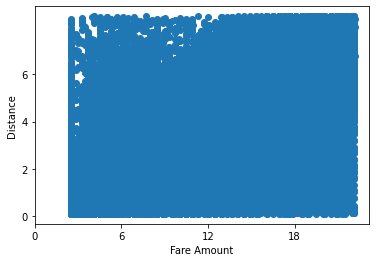

In [ ]:
## PLOT DATA ##
plt.scatter(data.iloc[:,1], data.iloc[:,8])
plt.xticks(np.arange(0,23,step=6))
plt.yticks(np.arange(0,7,step=2))
plt.xlabel("Fare Amount")
plt.ylabel("Distance")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


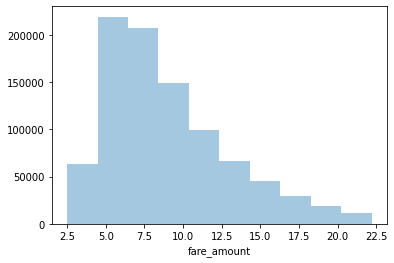

In [ ]:
sn.distplot(data['fare_amount'], kde=False, bins=10)    # Display fare amount distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


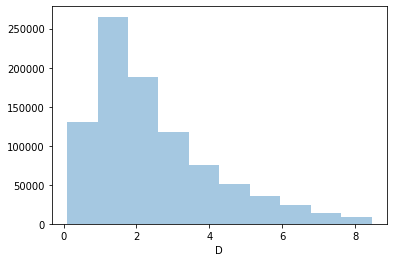

In [ ]:
sn.distplot(data['D'], kde=False, bins=10)    # Display distance distribution

In [ ]:
## DETERMINE LOCATION POINTS AFTER CLEANING ##

from geopy.distance import lonlat
m = len(data)
pickup_points = []

for i in range(m):  
  p = lonlat(data.iloc[i,3], data.iloc[i,4])  ## longitude, latitude
  pickup_points.append(p)

In [ ]:
dropoff_points = []

for i in range(m):  
  p = lonlat(data.iloc[i,5], data.iloc[i,6])  ## longitude, latitude
  pickup_points.append(p)

Plot of pickup and dropoff locations with greater circle and brighter color for larger fare amounts

Text(0.5, 1.0, 'pickup locations')

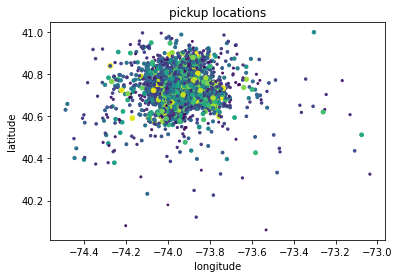

In [ ]:
plt.scatter(data.iloc[:,3], data.iloc[:,4],s=data.fare_amount, c=data.fare_amount)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("pickup locations")

Text(0.5, 1.0, 'dropoff locations')

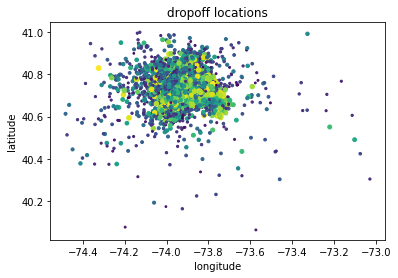

In [ ]:
plt.scatter(data.iloc[:,5], data.iloc[:,6],s=data.fare_amount, c=data.fare_amount)
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.title("dropoff locations")

In [ ]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime']) # change feature type from object to datetime
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,D
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.029601
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389132
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,2.795790
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.998338
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,3.787980


In [ ]:
#weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#months = ['January','February','March','April', 'May','June','July','August','September','October','November','December']
#for the regression problem numerical values are needed
wd = []
month = []
year = []
hour = []
for i in range(m):
  wd.append(data.iloc[i,2].weekday())
  month.append(data.iloc[i,2].month-1)
  year.append(data.iloc[i,2].year)
  hour.append(data.iloc[i,2].hour)

In [ ]:
data['wd'] = wd
data['month'] = month
data['year'] = year
data['hour'] = hour


In [ ]:
data = data.drop(columns=['key', 'pickup_datetime'])
data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,D,wd,month,year,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,1.029601,0,5,2009,17
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,1.389132,3,7,2011,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2.795790,5,3,2012,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,1.998338,1,2,2010,7
5,12.1,-74.000964,40.731630,-73.972892,40.758233,1,3.787980,3,0,2011,9


In [ ]:
data.to_csv(r'/content/sample_data/final_df.csv',index=None)    # Save final dataset file for further ML tasks

In [ ]:
# Generate feature and target array for a first linear regression with all features, to predict the fare
m=len(data)
y = data.values[:,0].reshape(m,1)
feat = data.drop(columns=['fare_amount'])
m, n = feat.shape
X = feat.values.reshape(m,n)

X, y

(array([[-7.38443110e+01,  4.07213190e+01, -7.38416100e+01, ...,
          5.00000000e+00,  2.00900000e+03,  1.70000000e+01],
        [-7.39827380e+01,  4.07612700e+01, -7.39912420e+01, ...,
          7.00000000e+00,  2.01100000e+03,  0.00000000e+00],
        [-7.39871300e+01,  4.07331430e+01, -7.39915670e+01, ...,
          3.00000000e+00,  2.01200000e+03,  4.00000000e+00],
        ...,
        [-7.39638880e+01,  4.07679920e+01, -7.39740170e+01, ...,
          5.00000000e+00,  2.01200000e+03,  1.90000000e+01],
        [-7.39723280e+01,  4.07452770e+01, -7.39876820e+01, ...,
          0.00000000e+00,  2.01400000e+03,  1.90000000e+01],
        [-7.39805756e+01,  4.07781448e+01, -7.39862518e+01, ...,
          2.00000000e+00,  2.01500000e+03,  1.30000000e+01]]), array([[ 4.5],
        [ 5.7],
        [ 7.7],
        ...,
        [ 6.9],
        [12. ],
        [13. ]]))

# Fare Amount Prediction with linear regression





In [ ]:
## prediction of fare amount with passenger count and distance ##

import sklearn
from sklearn import linear_model

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.1)  ## extract test and training set automatically from X and y

model=linear_model.LinearRegression()
model.fit(x_train,y_train)
acc=model.score(x_test,y_test)  ## accuracy of the regression model fit to the data with respect to the test set
acc, model.coef_, model.intercept_  ##accuracy, coefficients learned(thetas), intercept value

predictions=model.predict(x_test)
for i in range(len(predictions)):
  predictions[i],x_test[i],y_test[i]


r2=sklearn.metrics.r2_score(y_test, predictions)                      # Accuracy
EV = sklearn.metrics.explained_variance_score(y_test, predictions)    # Explained Variance
MaxE = sklearn.metrics.max_error(y_test, predictions)                 # Maximum Error
MAE = sklearn.metrics.mean_absolute_error(y_test, predictions)        # Mean Absolute Error
MSE = sklearn.metrics.mean_squared_error(y_test, predictions)         # Mean Squared Error - most useful indicator of the prediction deviation from the actual result, as units of measurement are the same

r2, MAE, MSE, MaxE, EV


(0.7114923814169053,
 1.5306244318006357,
 4.604888247061932,
 19.470682429653266,
 0.7114923911496105)

Some correlations among the features are analysed

In [ ]:
from scipy.stats.stats import pearsonr
print ("Corr between Fare Amount and all other parameters")
print (data.corr('pearson')["fare_amount"])

Corr between Fare Amount and all other parameters
fare_amount          1.000000
pickup_longitude    -0.000007
pickup_latitude     -0.088972
dropoff_longitude    0.079827
dropoff_latitude    -0.113414
passenger_count      0.014644
D                    0.824067
wd                   0.020263
month                0.028929
year                 0.151570
hour                -0.005048
Name: fare_amount, dtype: float64


From the pearson correlation between fare amount vs. all other features it can be seen that distance and year have the highest correlation. From the location features the dropoff latitude is the most correlated (inversely) to the fare amount.

Further relations plotted:

Text(0, 0.5, 'Frequency')

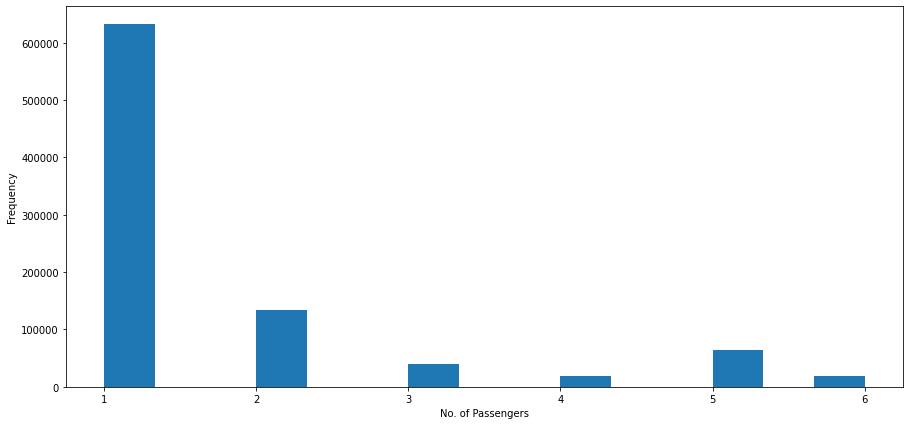

In [ ]:
# Plot frequency of number of passengers in the data
plt.figure(figsize=(15,7))
plt.hist(data['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

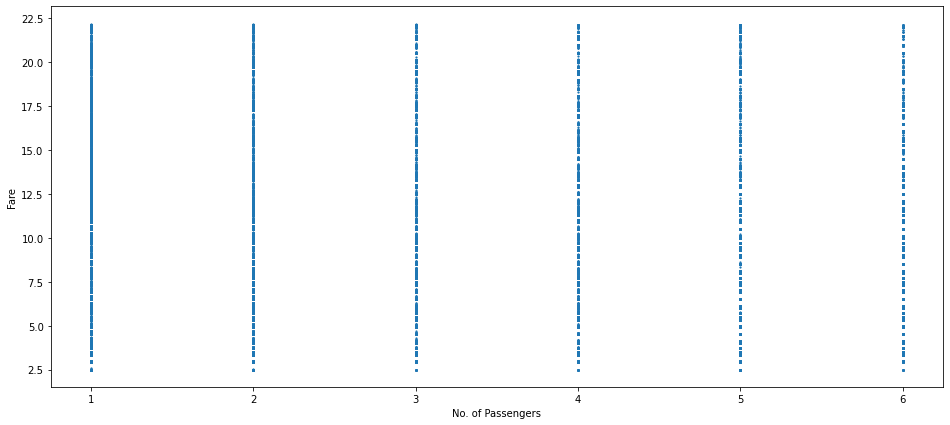

In [ ]:
# Plot relation of fare to number of passengers
plt.figure( figsize = (16,7))
plt.scatter(x=data['passenger_count'], y=data['fare_amount'], s = 1.5)
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

Text(0, 0.5, 'freq')

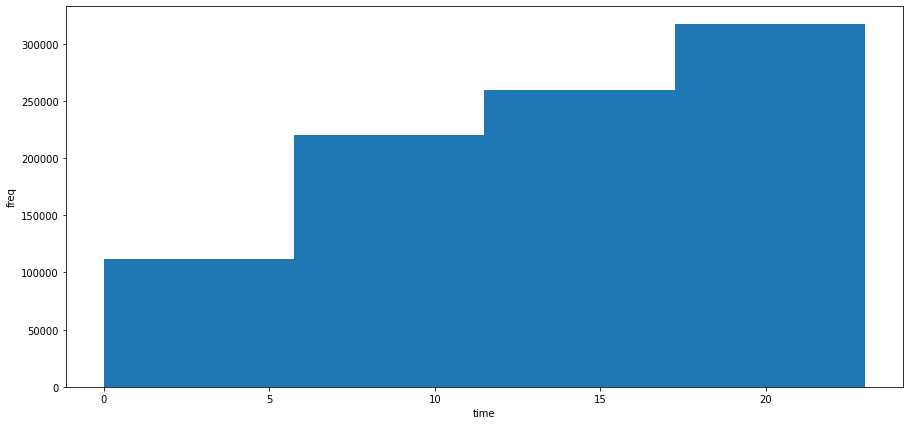

In [ ]:
# Plot frequency of taxi rides for each time of the day
plt.figure(figsize = (15,7))
plt.hist(data['hour'],bins = 4)
plt.xlabel('time')
plt.ylabel('freq')

Text(0, 0.5, 'freq')

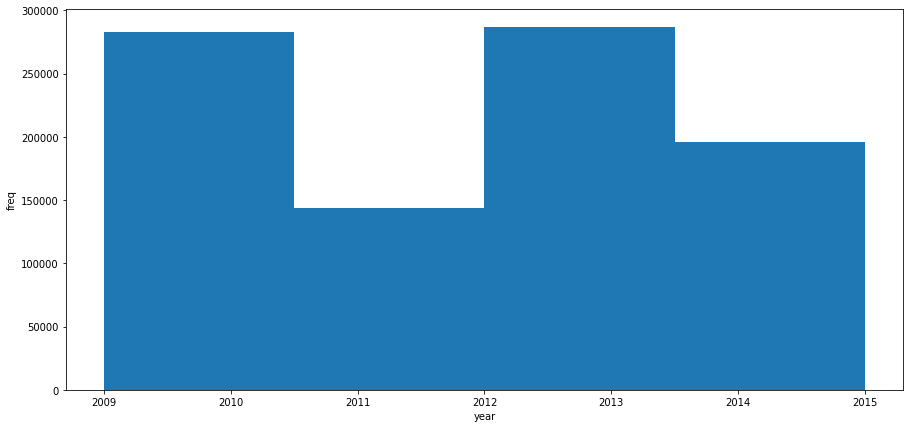

In [ ]:
# Plot frequency of taxi rides for each year
plt.figure(figsize = (15,7))
plt.hist(data['year'],bins = 4)
plt.xlabel('year')
plt.ylabel('freq')